<a href="https://colab.research.google.com/github/lazeicoder/Spam-and-smishing-detection-/blob/master/MulticlassRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from scipy.sparse import hstack


In [2]:
df = pd.read_csv("Dataset_10191.csv")


In [3]:
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["LABEL"])

label_mapping = dict(zip(
    label_encoder.classes_,
    label_encoder.transform(label_encoder.classes_)
))

print("Label Mapping:", label_mapping)


Label Mapping: {'ham': np.int64(0), 'smishing': np.int64(1), 'spam': np.int64(2)}


In [4]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=8000,
    stop_words="english"
)

X_text = tfidf.fit_transform(df["TEXT"])


In [5]:
X_meta = (
    df[["URL", "EMAIL", "PHONE"]]
    .replace({"Yes": 1, "No": 0})
    .astype(int)
    .values
)


/tmp/ipython-input-4199362701.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})


In [6]:
X = hstack([X_text, X_meta])
y = df["label_enc"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


In [9]:
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [10]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)


In [11]:
accuracy = accuracy_score(y_test, y_pred)

macro_roc_auc = roc_auc_score(
    y_test,
    y_prob,
    multi_class="ovr",
    average="macro"
)

print("Accuracy:", accuracy)
print("Macro ROC-AUC:", macro_roc_auc)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9798921039725356
Macro ROC-AUC: 0.9989041793978007

Classification Report:
              precision    recall  f1-score   support

         ham     0.9971    0.9985    0.9978       679
    smishing     0.9693    0.9735    0.9714       680
        spam     0.9734    0.9676    0.9705       680

    accuracy                         0.9799      2039
   macro avg     0.9799    0.9799    0.9799      2039
weighted avg     0.9799    0.9799    0.9799      2039


Confusion Matrix:
[[678   1   0]
 [  0 662  18]
 [  2  20 658]]


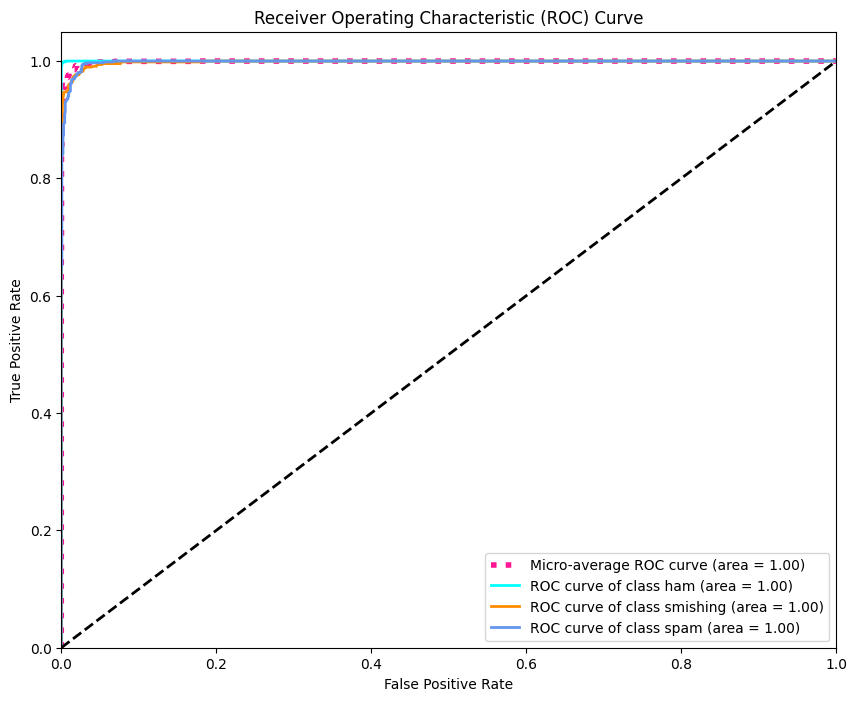

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle

# Binarize the output for multi-class ROC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Micro-average ROC curve
# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC curve (area = {roc_auc_micro:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {label_encoder.inverse_transform([i])[0]} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

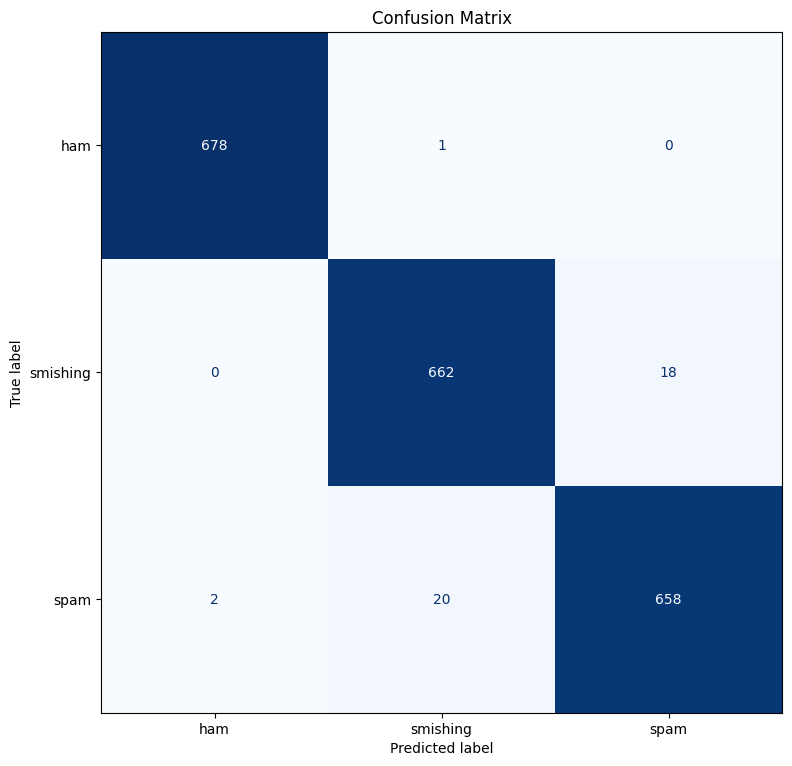

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix display
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    ax=ax,
    colorbar=False
)

ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()